# Import modules

In [2]:
import sys
from unipath import Path

# append codelib to sys path ~ will only work if this jupyter notebook path is sys.path[0]
p = Path(sys.path[0])
codelib_path = str(p.parent + Path('\\codelib'))
sys.path.insert(0, codelib_path)

# import codelib
from structure_functions import *
from mean_variance import *

In [3]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random
from sklearn.model_selection import train_test_split

### Collect closing prices

In [7]:
# loading dataframe with adj closing prices of SP500
df = pd.read_csv(r"C:\Users\Gustav\Dropbox\1. Copenhagen Business School\master\master thesis\empirical_testing\MVO\data_close_price.csv")

In [8]:
col_drop = []

for col in df.columns:
    
    if df[str(col)].isna().sum() > 1:
        col_drop.append(col)
    
df = df.drop(col_drop, axis=1)

In [9]:
df_ret = df.iloc[:,1:].pct_change()
df_ret.insert(loc=0, column="date", value=df["Date"])
df_ret.iloc[0,1:] = 0

### Train-test split

In [10]:
train_df, test_df = train_test_split(df_ret, test_size=0.2, shuffle=False)

train = (train_df.iloc[:,1:].to_numpy()).T
test = (test_df.iloc[:,1:].to_numpy()).T

In [15]:
# configuration of data pull
start = "2020-01-01"
end = "2021-12-31"
tickers = ['AAPL','MSFT','AMZN','TSLA','IBM','SPY','DIS','COST','TGT','DAL']

# codelib/structure_functions.daily_returns()
returns_df = daily_return(start, end, tickers)
returns = returns_df.to_numpy()

Dropped 0 rows


### Calculate input variables

1. Return.
2. Vairance.
3. Covariance matrix.

In [6]:
mean = []
variance = []

for idx in range(len(train)):
    
    # returns and variance
    mean_idx = np.mean(train[idx])
    var_idx = np.var(train[idx])
    
    mean.append(mean_idx)
    variance.append(var_idx)


# store in array
ret_var = np.array([mean, variance])
corr = np.corrcoef(train)
input_variables = np.concatenate((ret_var, corr))

In [7]:
ret = input_variables[0]
var = input_variables[1]
std = np.sqrt(var)
corr = input_variables[2:]
cov_mat = np.cov(train)

### Mean Variance optimization

In [9]:
opt = mean_variance(ret, var, cov_mat.T, train)

In [10]:
mv_returns  = efficient_frontier(ret, var, cov_mat, train)['returns']
mv_variance = efficient_frontier(ret, var, cov_mat, train)['std']

mv_global_returns  = efficient_frontier(ret, var, cov_mat, train)['returns_global']
mv_global_variance = efficient_frontier(ret, var, cov_mat, train)['std_global']

# initialize mean variance optimization
opt = mean_variance(ret, std, cov_mat, train)

# minimum variance portfolio
min_ret = opt.min_var_return()
min_std = np.sqrt(opt.min_var_variance())

# max slope portfolio
max_ret = opt.max_slope_return()
max_std = np.sqrt(opt.max_slope_variance())

# tangency portfolio
tan_ret = opt.tan_port_return()
tan_std = np.sqrt(opt.tan_port_variance())

#### Plot the Mean Variance optimization

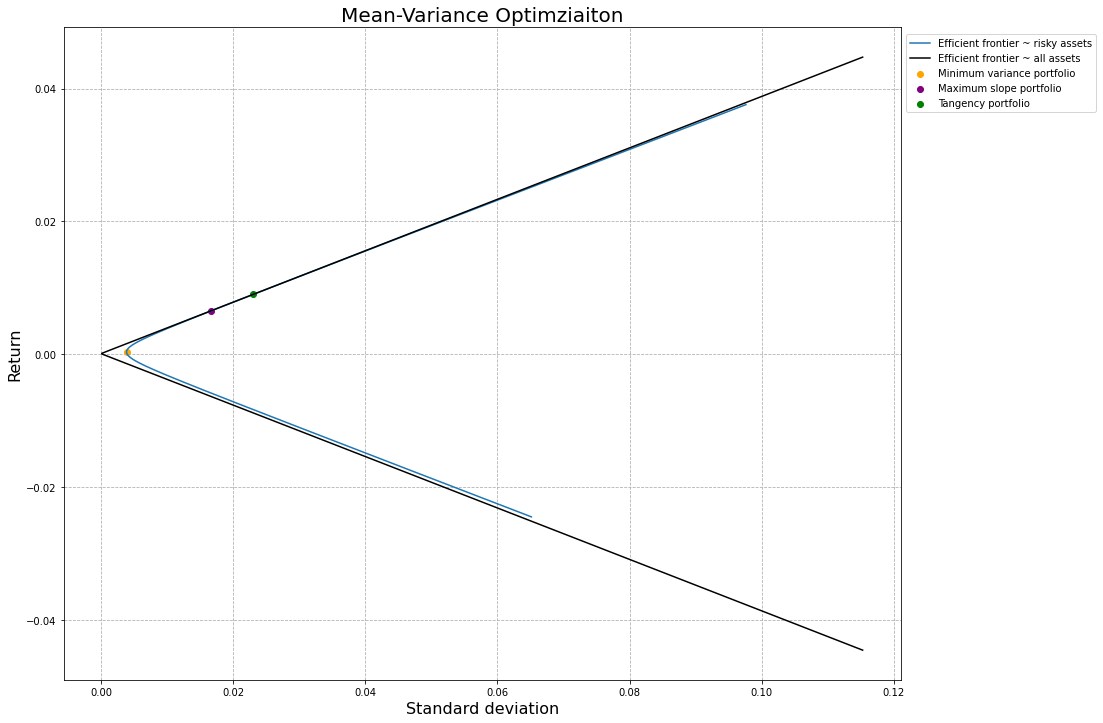

In [11]:
# plotting
plt.figure(figsize=(15,12))
plt.plot(mv_variance, mv_returns, label="Efficient frontier ~ risky assets")
plt.plot(mv_global_variance, mv_global_returns, color="black", label="Efficient frontier ~ all assets")

plt.scatter(min_std, min_ret, color="orange", label="Minimum variance portfolio")
plt.scatter(max_std, max_ret, color="purple", label="Maximum slope portfolio")
plt.scatter(tan_std, tan_ret, color="green", label="Tangency portfolio")

plt.title("Mean-Variance Optimziaiton", size=20)
plt.xlabel("Standard deviation", size=16)
plt.ylabel("Return", size=16)

plt.grid(linestyle="--")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.93))

plt.show()

### Return in test period

In order to evaluate the portfolios, the test data is brought in use. The weights of the tangency portfolio will be actioned by multiplying them on the return of the stocks during the test period. In order to make any relative evaluation the equal weighted portfolio will be used as the benchmark.

1. Get cumulative return of each stock in test period.
2. Calculate return of tangency portfolio in test period.
3. Calculate return of equal weighted portfolio in test period.

In [12]:
# cumulative return in test period for each stock
cum_return = np.cumprod((test+1), axis=1)

# calculate returns of tangency portfolio in test period
tan_weights = opt.tan_port_weights()
tan_weight_ret = (tan_weights * test.T).T
tan_ret = np.sum(tan_weight_ret, axis=0)

# cumulative returns of tangency portfolio in test period
cum_tan_ret = np.cumprod(tan_ret+1)

# calculate returns of equal weighted portfolio in test period
eq_weights = np.ones(len(test)) / len(test)
eq_weight_ret = (eq_weights * test.T).T
eq_ret = np.sum(eq_weight_ret, axis=0)

# cumulative returns of equal weighted portfolio in test period
cum_eq_ret = np.cumprod(eq_ret+1)

In [13]:
tan = np.round(((cum_tan_ret[-1]-1)*100), 2)
eq = np.round(((cum_eq_ret[-1]-1)*100), 2)

print("Return of tangency portfolio:",tan,"%")
print("Return of equal weighted portfolio:",eq,"%")

Return of tangency portfolio: 59.38 %
Return of equal weighted portfolio: 55.13 %


#### Plotting cumulative return of portfolios

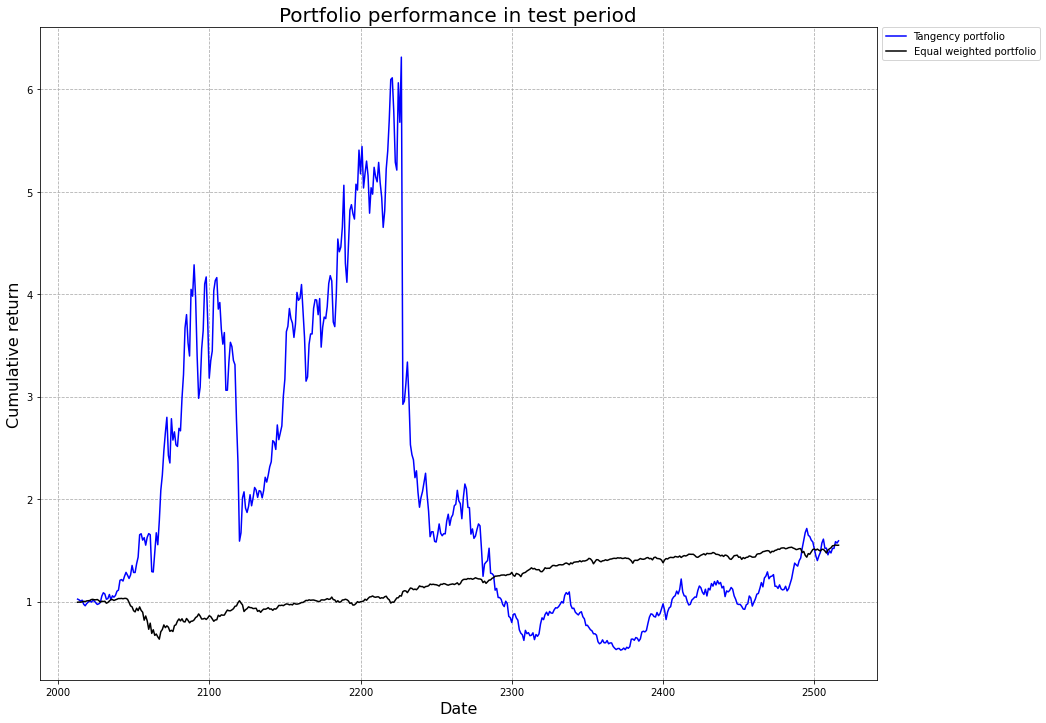

In [14]:
# plotting
plt.figure(figsize=(15,12))
plt.plot(test_df.index, cum_tan_ret, color="blue", label="Tangency portfolio")
plt.plot(test_df.index, cum_eq_ret, color="black", label="Equal weighted portfolio")

plt.title("Portfolio performance in test period", size=20)
plt.xlabel("Date", size=16)
plt.ylabel("Cumulative return", size=16)

plt.grid(linestyle="--")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.975))

plt.show()